In [18]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install torch
# %pip install torchvision
# %pip install scikit-learn
# %pip install tensorflow
# %pip install pennylane
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.decomposition import PCA
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings("ignore")

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [ ]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [3]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [4]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


#### Check data

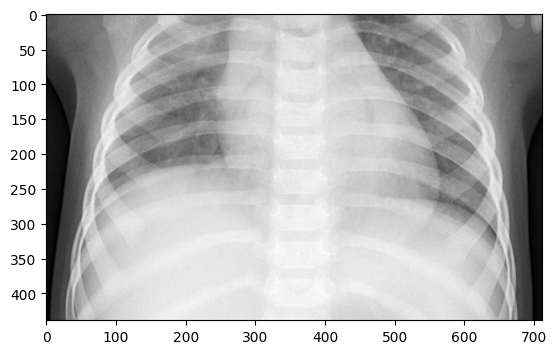

In [5]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

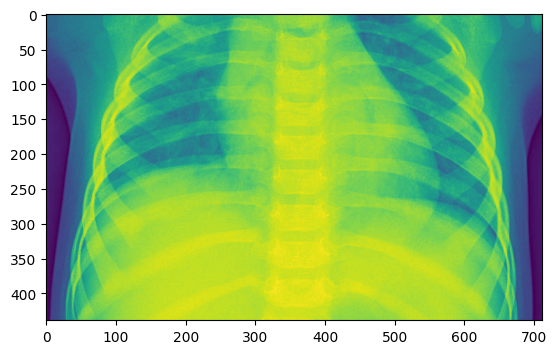

In [6]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [7]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


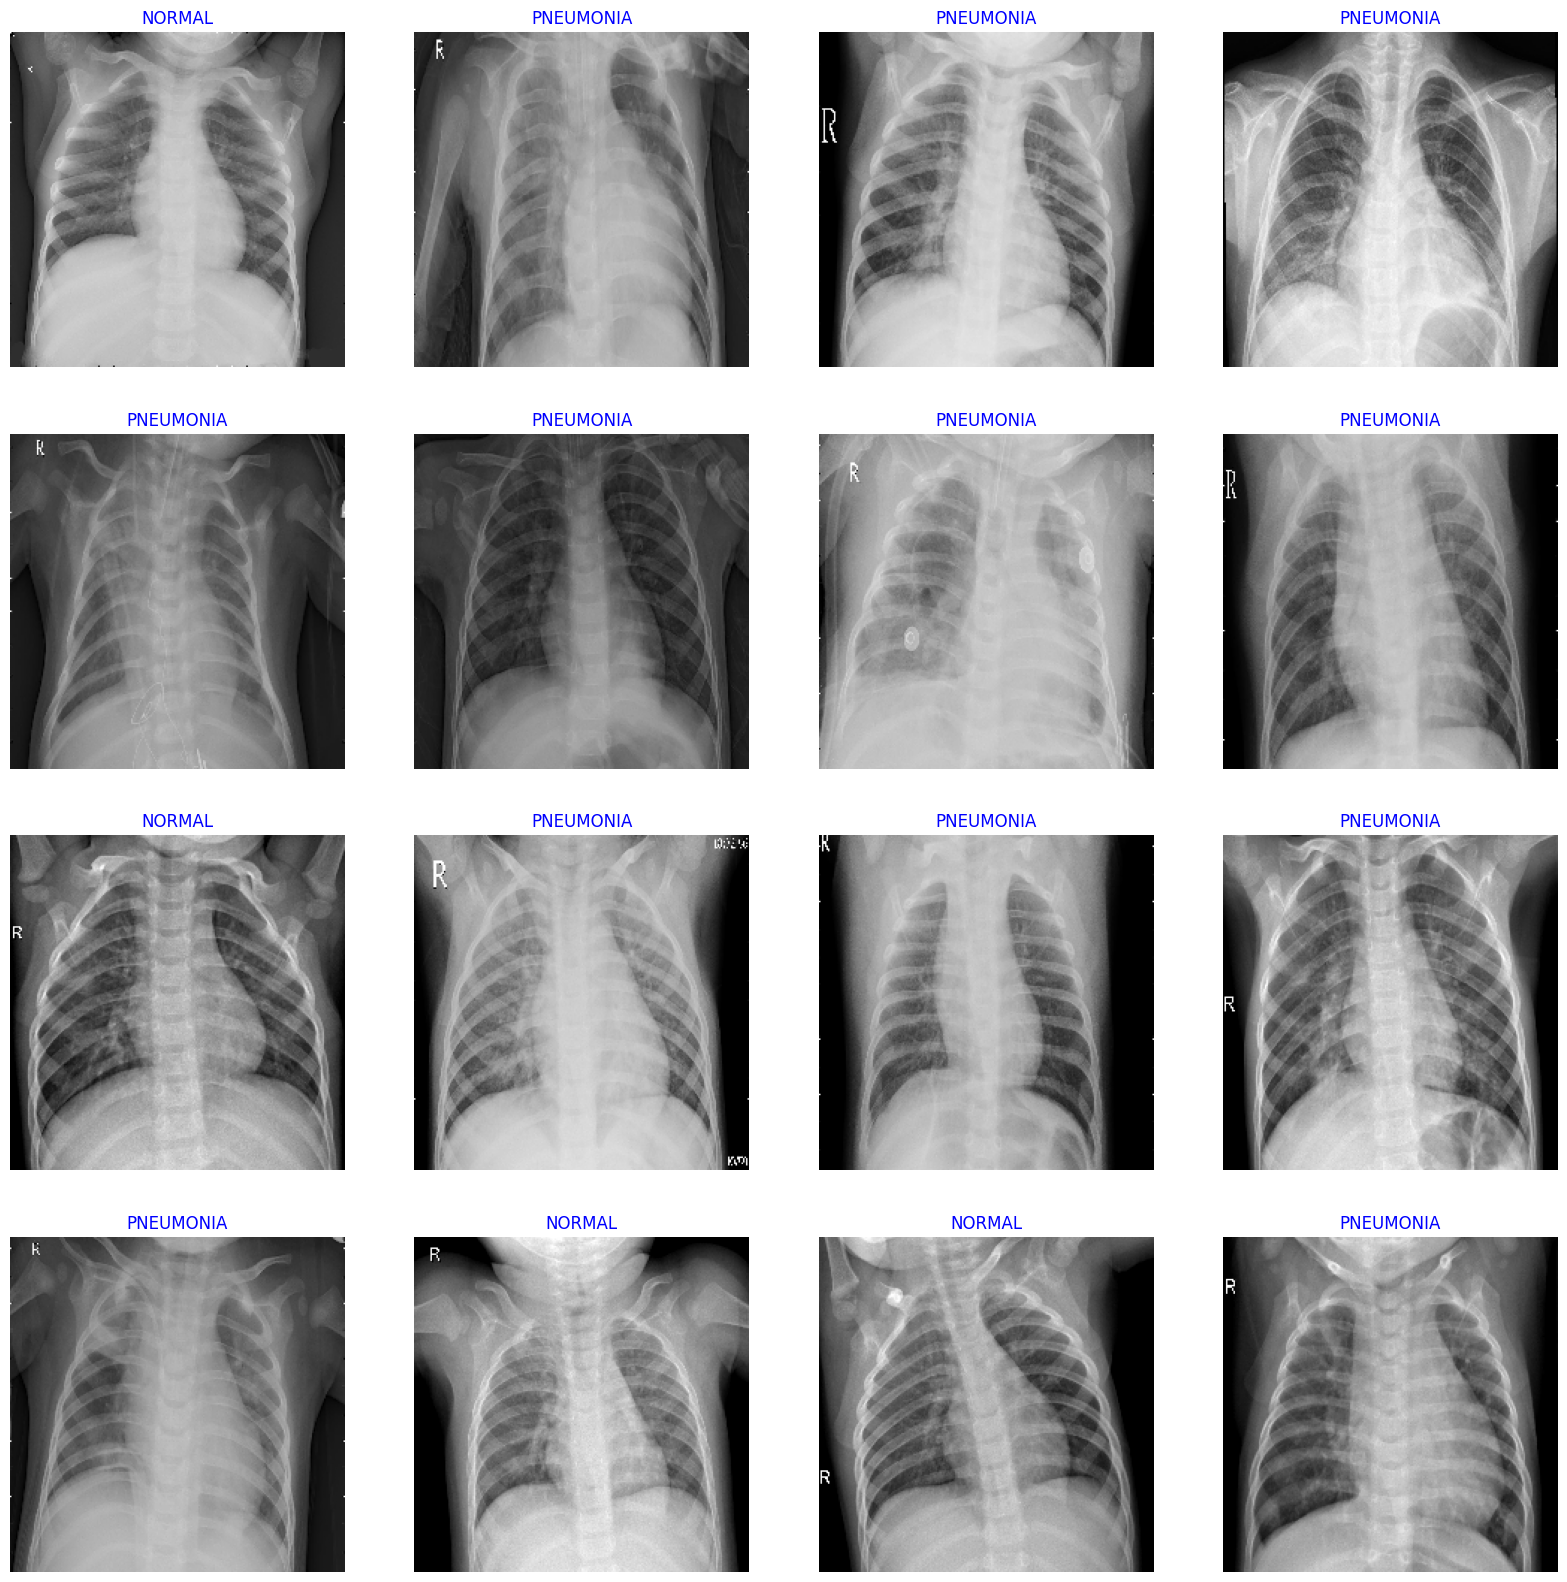

In [8]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [9]:
num_samples = 250
num_samples_test = 50

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

In [31]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

#### Display the categorized file paths and labels

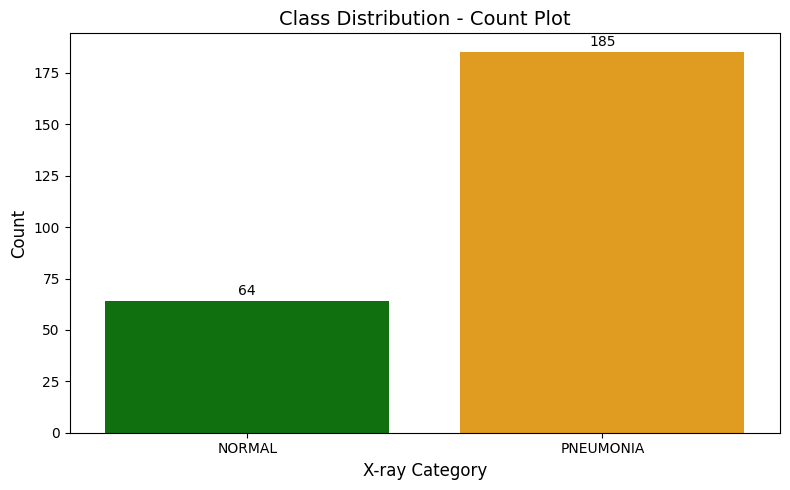

In [11]:
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### The number of qubits

In [12]:
num_qubits = 4

#### Initial random weights for the quantum layer

In [13]:
weights = pnp.random.random(size=(3, num_qubits, 3), requires_grad=True)

#### Quantum device setup

In [14]:
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="torch")
def quantum_layer(inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

#### Setting quantum model

In [15]:
class QuantumLayer(nn.Module):
    def forward(self, x):
        q_out = [torch.tensor(quantum_layer(x[i]), dtype=torch.float32) for i in range(x.shape[0])]
        return torch.stack(q_out)

class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Reducing the flattened size for the quantum layer input
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))  # Pooling to reduce spatial size
        self.flattened_size = 128 * 2 * 2  # 128 channels, 2x2 after pooling

        # Quantum layer
        self.quantum_layer = QuantumLayer()
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size + num_qubits, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)  # Apply global pooling to reduce size to 2x2
        x = x.reshape(x.size(0), -1)  # Flatten

        # Select the first four features to pass to the quantum layer
        quantum_input = x[:, :num_qubits]
        q_out = self.quantum_layer(quantum_input)
        
        # Concatenate classical and quantum outputs
        x = torch.cat((x, q_out), dim=1)

        # Fully connected layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Initialize the model, criterion, optimizer

In [16]:
quantum_model = QuantumCNN(num_classes=2)

#### Training function

In [17]:
def fit_quantum_model(model, X_train, y_train, epochs=20, batch_size=32, patience=5):
    """
    Trains the QuantumCNN model using the provided training data.

    Args:
        model: QuantumCNN model instance to be trained.
        X_train (numpy array): Training image data, originally of shape (num_samples, 128, 128, 3).
        y_train (numpy array): Training labels.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.
        patience (int): Early stopping patience.

    Returns:
        dict: Training history containing loss and accuracy per epoch.
    """
    model.train()
    history = {'loss': [], 'accuracy': []}

    if X_train.ndim == 2:
        X_train = X_train.reshape(-1, 224, 224, 3)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            acc = (predicted == y_batch).float().mean().item()
            epoch_accuracy += acc

        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history


#### Training the model

In [18]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=20)

Epoch [1/20], Loss: 0.5418, Accuracy: 0.7378
Epoch [2/20], Loss: 0.3866, Accuracy: 0.7836
Epoch [3/20], Loss: 0.3457, Accuracy: 0.8283
Epoch [4/20], Loss: 0.3005, Accuracy: 0.8472
Epoch [5/20], Loss: 0.2789, Accuracy: 0.8706
Epoch [6/20], Loss: 0.2695, Accuracy: 0.8583
Epoch [7/20], Loss: 0.2674, Accuracy: 0.8745
Epoch [8/20], Loss: 0.2697, Accuracy: 0.8739
Epoch [9/20], Loss: 0.2512, Accuracy: 0.8934
Epoch [10/20], Loss: 0.2792, Accuracy: 0.8813
Epoch [11/20], Loss: 0.2461, Accuracy: 0.8834
Epoch [12/20], Loss: 0.2496, Accuracy: 0.8891
Epoch [13/20], Loss: 0.2278, Accuracy: 0.9102
Epoch [14/20], Loss: 0.2079, Accuracy: 0.9041
Epoch [15/20], Loss: 0.2132, Accuracy: 0.8973
Epoch [16/20], Loss: 0.1833, Accuracy: 0.9169
Epoch [17/20], Loss: 0.2870, Accuracy: 0.8973
Epoch [18/20], Loss: 0.2887, Accuracy: 0.8544
Epoch [19/20], Loss: 0.2924, Accuracy: 0.8316
Epoch [20/20], Loss: 0.2233, Accuracy: 0.8963


#### Plotting accuracy and loss

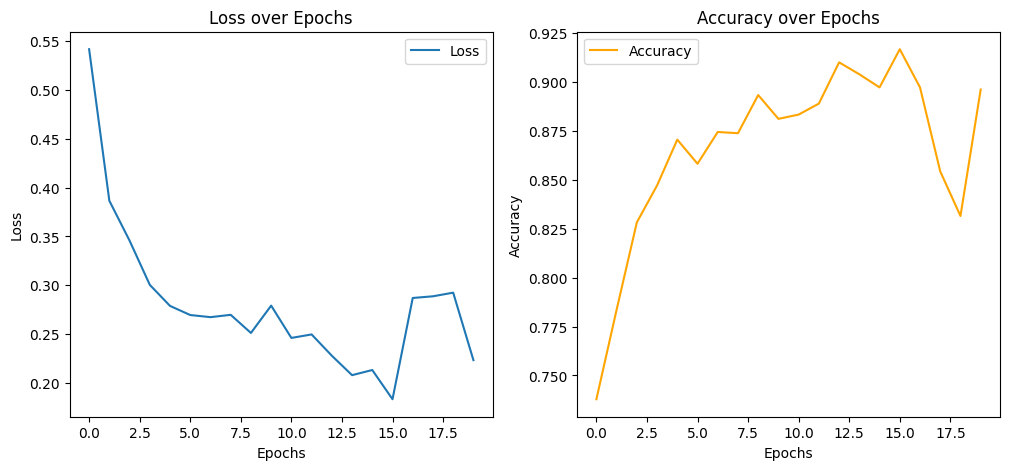

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### The evaluation of model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

quantum_model.eval()
X_test = X_test.reshape(-1, 224, 224, 3)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

with torch.no_grad():
    outputs = quantum_model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_test_indices = torch.tensor(y_test, dtype=torch.long).to(device) 
y_test_labels = y_test_indices.cpu().numpy()

print(f"Accuracy: {metrics.accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print("Classification Report:")
print(metrics.classification_report(y_test_labels, y_pred, target_names=["Normal", "Tumor"]))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test_labels, y_pred))

if outputs.shape[1] > 1:
    y_prob = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
    print(f"ROC AUC Score: {metrics.roc_auc_score(y_test_labels, y_prob):.4f}")


Accuracy: 89.80%
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.58      0.74        12
       Tumor       0.88      1.00      0.94        37

    accuracy                           0.90        49
   macro avg       0.94      0.79      0.84        49
weighted avg       0.91      0.90      0.89        49

Confusion Matrix:
[[ 7  5]
 [ 0 37]]
ROC AUC Score: 0.8964


#### Predicted probability for Positive Class

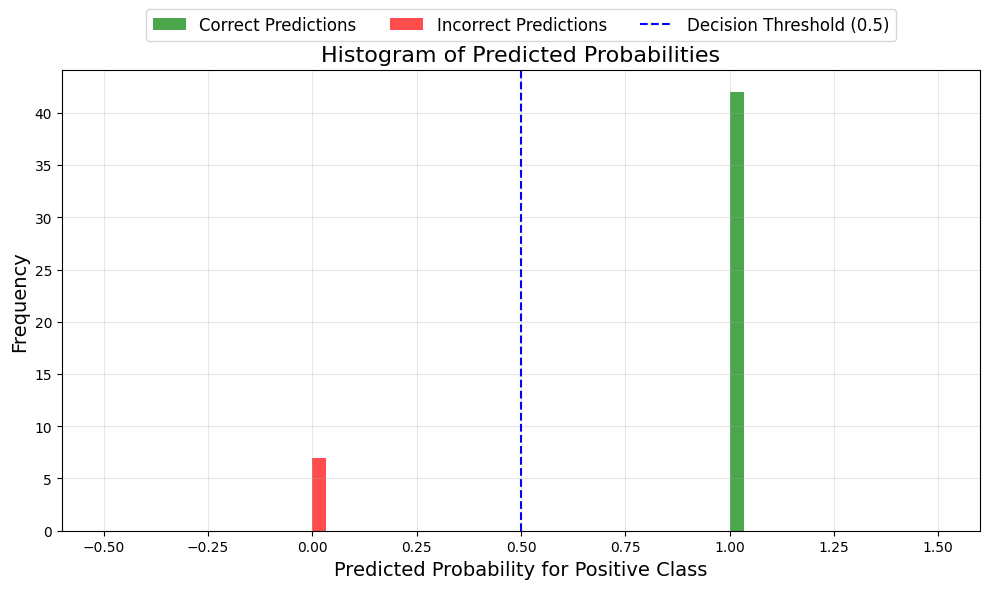

In [34]:
if isinstance(y_pred, np.ndarray):
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

predictions = torch.round(y_pred)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred[correct_predictions]
incorrect_probs = y_pred[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### PCA of model prediction

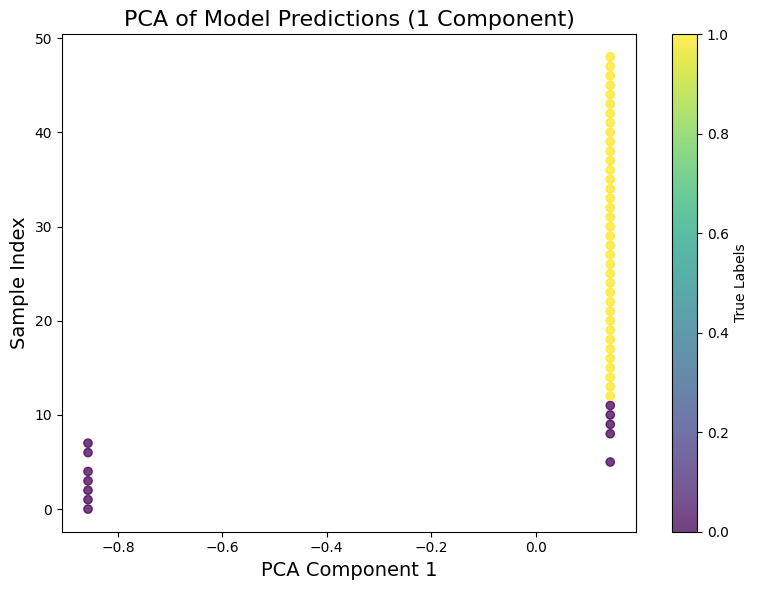

In [35]:
if y_test.ndim > 1:
    y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()
else:
    y_test_labels = torch.tensor(y_test).numpy()

labels_test_reshaped = y_pred.reshape(-1, 1)
pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

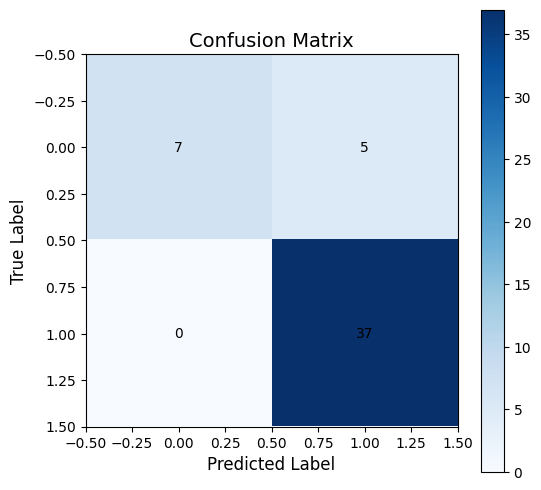

In [36]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()